#### Hartree-Fock in Pytorch

In [1]:
from src.hamiltonian_utils import FermiHubbardHamiltonian
from src.nuclear_physics_utils import get_twobody_nuclearshell_model,SingleParticleState
import numpy as np

from typing import Dict
import scipy
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
from scipy.sparse.linalg import eigsh,expm_multiply
from tqdm import trange
import matplotlib.pyplot as plt
from src.hartree_fock_library import HFEnergyFunctional,HFEnergyFunctionalNuclear
from scipy.sparse import lil_matrix
import torch
import torch.nn as nn
import torch.optim as optim

file_name='data/usdb.nat'


SPS=SingleParticleState(file_name=file_name)

In [2]:
twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [01:02<00:00,  2.61s/it]


In [3]:
nparticles_a=8
nparticles_b=2

size_a=SPS.energies.shape[0]//2
size_b=SPS.energies.shape[0]//2

title=r'$^{26}$Ne'

In [4]:

# Compute the J^2 value
#J2Class=J2operator(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,single_particle_states=SPS.state_encoding,j_square_filename=file_name+'_j2',symmetries=[SPS.total_M_zero])

#Quadrupole Operator


# compute the NSM Hamiltonian
NSMHamiltonian=FermiHubbardHamiltonian(size_a=size_a,size_b=size_b,nparticles_a=nparticles_a,nparticles_b=nparticles_b,symmetries=[SPS.total_M_zero])
print('size=',size_a+size_b,size_b)
NSMHamiltonian.get_external_potential(external_potential=SPS.energies[:size_a+size_b])
if file_name=='data/cki':
    twobody_matrix,energies=get_twobody_nuclearshell_model(file_name=file_name)

    NSMHamiltonian.get_twobody_interaction(twobody_dict=twobody_matrix)
else:
    NSMHamiltonian.twobody_operator=scipy.sparse.load_npz(f'data/nuclear_twobody_matrix/usdb_{nparticles_a}_{nparticles_b}.npz')
NSMHamiltonian.get_hamiltonian()

egs,psi0=NSMHamiltonian.get_spectrum(n_states=1)

print(egs)

print('total_m=',SPS.compute_m_exp_value(psi=psi0,basis=NSMHamiltonian.basis))
#print('j_value=',J2Class.j_value(psi0))
print('dimension=',NSMHamiltonian.hamiltonian.shape[0])

size= 24 12
[-87.14199175]
total_m= [1.49076204e-16]
dimension= 4206


Hartree-Fock method

In [9]:
#model=HFEnergyFunctional(h_vec=torch.tensor(SPS.energies),V_dict=twobody_matrix,num_particles=nparticles_a+nparticles_b)
model=HFEnergyFunctionalNuclear(h_vec=torch.tensor(SPS.energies,dtype=torch.double),V_dict=twobody_matrix,num_neutrons=nparticles_a,num_protons=nparticles_b,neutron_indices=0,proton_indices=12)


In [10]:

optimizer = optim.Adam(model.parameters(), lr=0.1)

num_steps = 200
for step in range(num_steps):
    optimizer.zero_grad()
    energy = model()  # calls forward()
    energy.backward()
    optimizer.step()

    if step % 20 == 0 or step == num_steps - 1:
        print(f"Step {step:4d} | Energy = {energy.item():.6f}")

tensor(5.5171, dtype=torch.float64, grad_fn=<SumBackward0>)
Step    0 | Energy = -49.818351
tensor(5.4567, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.3689, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.3497, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.3226, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.2855, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.2271, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.2035, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.2005, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.2414, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.2565, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.2541, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.3027, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.3731, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.4219, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5.4926, dtype=torch.float64, grad_fn=<SumBackward0>)
tensor(5

In [11]:
print(torch.sum(torch.abs(model.C_p)))

tensor(6.1138, dtype=torch.float64, grad_fn=<SumBackward0>)


In [ ]:
def slater_determinants_combined(C_n, C_p, fock_basis):
    """
    C_n: [M_half, N_n]  -- neutron orbitals
    C_p: [M_half, N_p]  -- proton orbitals
    fock_basis: [F, M]  -- full occupation basis (neutrons + protons)

    Returns:
        psi: [F]  -- Slater determinant amplitudes
    """
    F, M = fock_basis.shape
    M_half = M // 2
    N_n = C_n.shape[1]
    N_p = C_p.shape[1]

    psi = torch.zeros(F, dtype=C_n.dtype)

    for i in range(F):
        occ = fock_basis[i]  # [M]

        occ_n = torch.nonzero(occ[:M_half]).squeeze()
        occ_p = torch.nonzero(occ[M_half:]).squeeze()+M_half

        Cn_sub = C_n[occ_n, :]  # shape [N_n, N_n]
        Cp_sub = C_p[occ_p, :]  # shape [N_p, N_p]

        if Cn_sub.shape[0] != N_n or Cp_sub.shape[0] != N_p:
            # Skip invalid configurations (e.g., wrong number of particles)
            continue

        det_n = torch.det(Cn_sub)
        det_p = torch.det(Cp_sub)
        psi[i] = det_n * det_p

    return psi  # [F]


In [35]:

psi_hf=slater_determinants_combined(model.C_n, model.C_p, torch.tensor(NSMHamiltonian.basis))

psi_hf=psi_hf.detach().numpy()

psi_hf=psi_hf/np.linalg.norm(psi_hf)



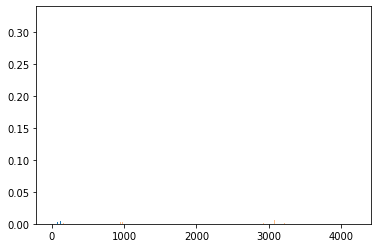

-68.92681856574774
fidelity= 0.0018209360411231429


In [36]:
plt.bar(np.arange(psi_hf.shape[0]),psi_hf.conjugate()*psi_hf)
plt.bar(np.arange(psi_hf.shape[0])+0.1,psi0[:,0].conjugate()*psi0[:,0],alpha=0.5)
plt.show()

print(psi_hf.conjugate() @ NSMHamiltonian.hamiltonian @ psi_hf)


print('fidelity=',psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)))

In [68]:
def check_orthonormal(C, tol=1e-6):
    I = torch.eye(C.shape[1], dtype=C.dtype, device=C.device)
    test = C.T @ C
    return torch.allclose(test, I, atol=tol)

print(check_orthonormal(model.C))

True


#### Sample Based Diagonalization HF and exact Gs

In [11]:
n_instances=9000

In [71]:
prob_exact=np.conjugate(psi0[:,0])*psi0[:,0]
nbatch=50
ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_gs=[]
energies_sdg_gs=[]
fidelities_exact=[]

deviations_exact=[]
for n_instances in ns_instances:
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch): 
                selection=np.random.choice(np.arange(prob_exact.shape[0]),size=n_instances,replace=False,p=prob_exact)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

                psi_selected[selection]=effective_psi0[:,0]
                
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
                std_energy+=effective_egs**2
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2

        fidelities_exact.append(ensamble_fidelity)
        errors_sdg_gs.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_gs.append(ensamble_energy)
        deviations_exact.append(std_energy)
        print(ensamble_energy)


-43.369976952476925
-48.71148372842649
-49.72053414263641
-50.48601782576776
-51.08681638550158
-51.623694618329694
-52.031295232537126
-52.41154733932853
-52.89528660652687
-53.247901301435355
-53.533562843931776
-53.940409272975096
-54.17485504549095
-54.4323849611634
-54.642175047255286
-54.85449944835798
-55.09692414320554
-55.351189333633855
-55.483002295824114
-55.677288596169085
-55.838497326722425
-55.961968480863916
-56.12247569281589
-56.22691634627849
-56.39417281936234
-56.49612830368803
-56.61031231162832
-56.69083033475188
-56.84054560111137
-56.92234509014177
-57.0222683333473
-57.1102345714543
-57.19310382543758
-57.27459487048885
-57.37065122396017
-57.435465281213055
-57.51359242793713
-57.59090649637437
-57.65007498195353
-57.705031769719454
-57.77547735985197
-57.831664781371735
-57.885098526396916
-57.95812847767457
-58.003315232498935
-58.057315692796855
-58.103707643381505
-58.16203437065461
-58.19296292484094
-58.24363924543542
-58.296161317143934
-58.3341185005

KeyboardInterrupt: 

In [48]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]
errors_sdg_hf=[]
energies_sdg_hf=[]
fidelities=[]

deviations=[]
for n_instances in ns_instances:
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch): 
                selection=np.random.choice(np.arange(prob_exact.shape[0]),size=n_instances,replace=False,p=prob_hf)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

                psi_selected[selection]=effective_psi0[:,0]
                
                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
                std_energy+=effective_egs**2
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2

        fidelities.append(ensamble_fidelity)
        errors_sdg_hf.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_hf.append(ensamble_energy)
        deviations.append(std_energy)
        print(ensamble_energy)


-23.272344569102188
-26.319074722734626
-27.801396310196132
-28.71590959810908
-29.359938244952733
-29.668193110240672
-30.176100261120794
-30.426521691865076
-30.940755287752122
-31.306040490183406
-31.673578636226097
-32.05763703579694
-32.374929478176064
-32.706037687182715
-32.94163008826983
-33.378486646400525
-33.64882609649974
-33.841535345528925
-34.001809582945015
-34.28585404819067
-34.539317002291725
-34.7632982193357
-34.97162246925323
-35.079507556349824
-35.32190172441712
-35.470048061277645
-35.65803520040802
-35.82125875176618
-35.96991246854239
-36.178095220633374
-36.26248696100311
-36.428853471183835
-36.59523129242596
-36.70194378853055
-36.79202915965322
-36.92940586243761
-37.05855885522858
-37.18008828236158
-37.23162893695888
-37.36991574650082
-37.49606793060554
-37.56732629297039
-37.67993025199828
-37.768078508962496
-37.85605293660162
-37.943747613822964
-38.004428320730334
-38.117680523895245
-38.176127195983376
-38.273010542844226
-38.33191591587792
-38.36

Useless

In [ ]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_hf_clever=[]
energies_sdg_hf_clever=[]
fidelities_clever=[]
max_iterations=100
prob_sampler=prob_hf.copy()
ns_instances_clever=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],5)
selection=np.random.choice(np.arange(prob_hf.shape[0]),size=2,replace=False,p=prob_hf)
selected_samples=[selection[0],selection[1]]
effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])

prob_sampler[selected_samples]=0
prob_sampler=prob_sampler/np.sum(prob_sampler)

effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
e_old=effective_egs.copy()

for r in range(NSMHamiltonian.hamiltonian.shape[0]-3): 
    
    low_energy=effective_egs.copy()
    for i in range(max_iterations):
        
        selection=np.random.choice(np.arange(prob_hf.shape[0]),size=5,replace=False,p=prob_sampler)
        tentative_selection=selected_samples+list(selection)
        
        effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[tentative_selection,:][:,tentative_selection]
        egs_tentative,psi0_tentative=eigsh(effective_hamiltonian,k=1,which='SA')

        if effective_egs <= low_energy:
            psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
            final_selection=tentative_selection
            low_energy=effective_egs
            effective_egs=egs_tentative.copy()
            psi_selected[tentative_selection]=psi0_tentative[:,0]
    print(effective_egs)
    selected_samples=final_selection
    prob_sampler[selected_samples]=0
    prob_sampler=prob_sampler/np.sum(prob_sampler)
    fidelities_clever.append(1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0])))
    errors_sdg_hf_clever.append(np.abs((effective_egs[0]-egs[0])/egs[0]))
    energies_sdg_hf_clever.append(effective_egs[0])

    
    

128 127


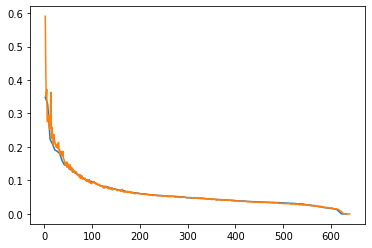

In [28]:
print(len(ns_instances_clever),len(errors_sdg_hf_clever))

plt.plot(ns_instances_clever[:-1],errors_sdg_hf_clever)
plt.plot(ns_instances,errors_sdg_hf)
plt.show()

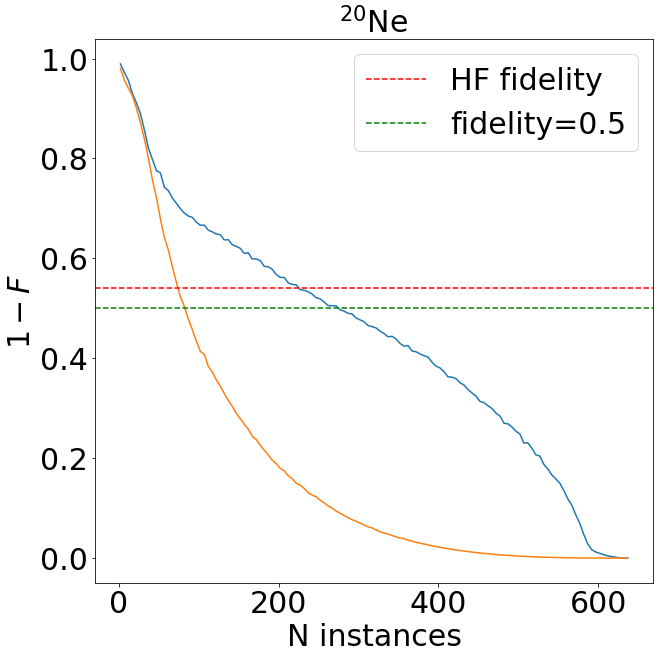

In [26]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,fidelities)
plt.plot(ns_instances,fidelities_exact)

plt.axhline(y=1-psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)),label='HF fidelity',color='red',linestyle='--')
plt.axhline(y=0.5,label='fidelity=0.5',color='green',linestyle='--')
plt.tick_params(labelsize=30)
plt.xlabel('N instances',fontsize=30)
plt.ylabel(r'$1-F$',fontsize=30)
plt.title(title,fontsize=30)
plt.legend(fontsize=30)
plt.show()

In [49]:
prob_hf=np.conjugate(psi_hf[:])*psi_hf[:]

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_hf_mixed=[]
energies_sdg_hf_mixed=[]
fidelities_mixed=[]
deviations_mixed=[]
nbatch=100


for n_instances in ns_instances: 
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch):
                selection=np.random.choice(np.arange(prob_hf.shape[0]),size=n_instances,replace=False,p=prob_hf)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
                

                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                std_energy+=effective_egs**2
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
        
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2
        
                
        prob_hf=0.95*prob_hf+0.05*ensamble_prob_selected
        prob_hf=prob_hf/np.sum(prob_hf)
        fidelities_mixed.append(ensamble_fidelity)
        errors_sdg_hf_mixed.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_hf_mixed.append(ensamble_energy)
        deviations_mixed.append(std_energy)
        print(effective_egs)

[-29.06032698]
[-29.8879764]
[-29.53260948]
[-28.602598]
[-29.4128596]
[-30.53406938]
[-30.99177912]
[-30.43950254]
[-31.24542575]
[-32.30378274]
[-31.61224185]
[-32.409607]
[-33.12901956]
[-33.31961956]
[-33.17674095]
[-34.28148546]
[-34.878804]
[-34.68286494]
[-34.76654134]
[-35.26496149]
[-35.6868123]
[-35.18182253]
[-35.66688697]
[-35.6463884]
[-36.03282671]
[-36.12097264]
[-36.60692651]
[-36.66169428]
[-36.70887562]
[-37.30966681]
[-37.27768684]
[-37.45113688]
[-37.64847602]
[-37.6304097]
[-37.75992802]
[-37.89892706]
[-38.13227113]
[-38.20874164]
[-38.23650362]
[-38.33439624]
[-38.49045397]
[-38.55346464]
[-38.61684505]
[-38.77668395]
[-38.74175506]
[-38.78629782]
[-38.94692384]
[-38.95912854]
[-38.94276597]
[-39.09470174]
[-39.17247436]
[-39.24308656]
[-39.29675139]
[-39.40017729]
[-39.37442486]
[-39.54461083]
[-39.53529353]
[-39.64368925]
[-39.66270792]
[-39.6879086]
[-39.76226122]
[-39.77197797]
[-39.7669164]
[-39.87196088]
[-39.88728727]
[-39.97751416]
[-39.98215589]
[-40.022

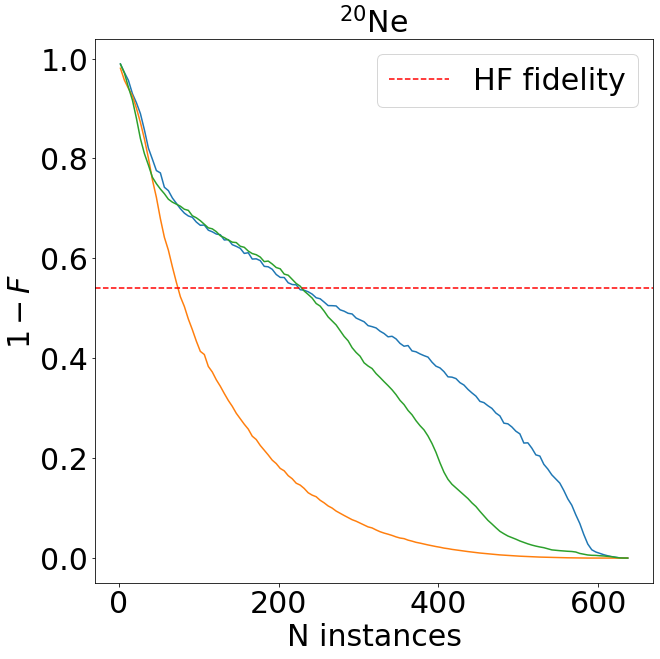

In [33]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,fidelities)
plt.plot(ns_instances,fidelities_exact)
plt.plot(ns_instances,fidelities_mixed)

plt.axhline(y=1-psi0[:,0].conjugate().dot(psi_hf)*np.conjugate(psi0[:,0].conjugate().dot(psi_hf)),label='HF fidelity',color='red',linestyle='--')

plt.tick_params(labelsize=30)
plt.xlabel('N instances',fontsize=30)
plt.ylabel(r'$1-F$',fontsize=30)
plt.title(title,fontsize=30)
plt.legend(fontsize=30)
plt.show()

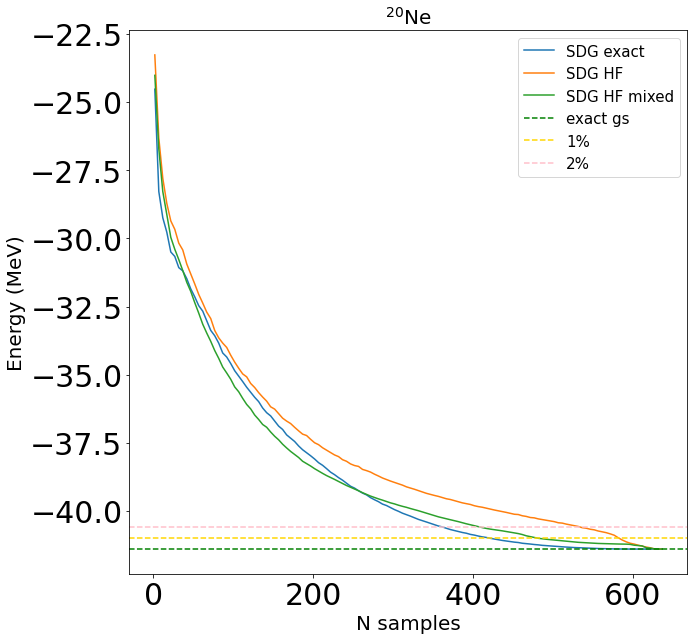

(128,)


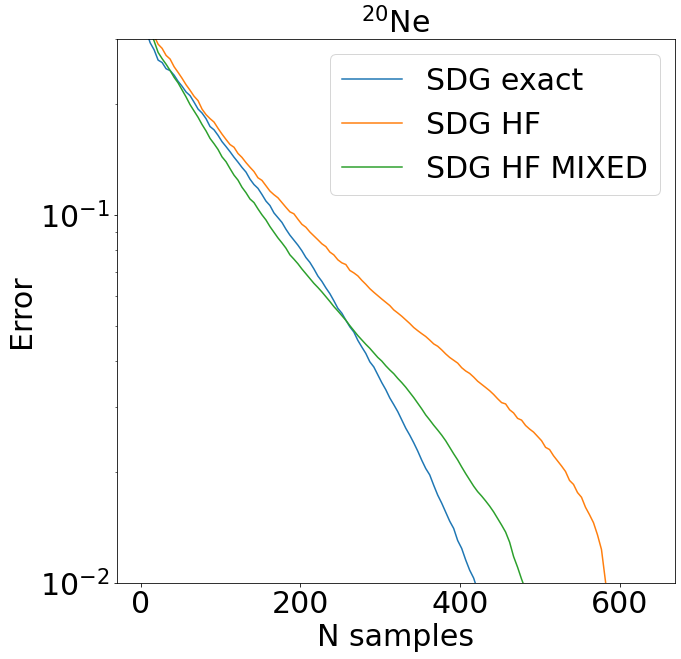

In [55]:
plt.figure(figsize=(10,10))
plt.plot(ns_instances,energies_sdg_gs,label='SDG exact')
plt.plot(ns_instances,energies_sdg_hf,label='SDG HF')
plt.plot(ns_instances,energies_sdg_hf_mixed,label='SDG HF mixed')
#plt.axhline(y=model().detach().numpy(),color='red',linestyle='--',label='HF')
plt.axhline(y=egs[0],color='green',linestyle='--',label='exact gs')
plt.axhline(y=egs[0]*(0.99),color='gold',linestyle='--',label='1%')
plt.axhline(y=egs[0]*(0.98),color='pink',linestyle='--',label='2%')
plt.xlabel('N samples',fontsize=20)
plt.ylabel('Energy (MeV)',fontsize=20)
plt.legend(fontsize=15)
plt.title(title,fontsize=20)
plt.tick_params(labelsize=30)
plt.show()

energies_sdg_hf=np.asarray(energies_sdg_hf)
energies_sdg_gs=np.asarray(energies_sdg_gs)
energies_sdg_hf_mixed=np.asarray(energies_sdg_hf_mixed)
print(energies_sdg_hf_mixed.shape)
plt.figure(figsize=(10,10))
plt.plot(ns_instances,np.abs((energies_sdg_gs-egs[0])/egs[0]),label='SDG exact')
plt.plot(ns_instances,np.abs((energies_sdg_hf-egs[0])/egs[0]),label='SDG HF')
plt.plot(ns_instances,np.abs((energies_sdg_hf_mixed-egs[0])/egs[0]),label='SDG HF MIXED')

plt.xlabel('N samples',fontsize=30)
plt.ylabel('Error',fontsize=30)
plt.tick_params(labelsize=30)
plt.ylim([10**-2,0.3])

plt.title(title,fontsize=30)
plt.semilogy()
plt.legend(fontsize=30)
plt.show()

#### Method using a Partial Adapt VQE

In [35]:
from src.hartree_fock_library import HartreeFock,HartreeFockVariational,gram_schmidt
from src.hamiltonian_utils import FermiHubbardHamiltonian
import numpy as np
from src.nuclear_physics_utils import SingleParticleState,get_twobody_nuclearshell_model
import torch
from typing import Dict,List
from src.qml_models import AdaptVQEFermiHubbard
from src.qml_utils.train import Fit
from src.qml_utils.utils import configuration
#from src.qml_models import AdaptVQEFermiHubbard
import matplotlib.pyplot as plt
from scipy import sparse
#from adapt_vqe_old import AdaptVQEFermiHubbard

In [15]:
def miquel_constrainer(idxs:List[int]):
    
    if SPS.projection_conservation(idxs=idxs):
        if NSMHamiltonian.charge_computation(initial_indices=idxs[:2],final_indices=idxs[2:]):
            op=NSMHamiltonian.adag_adag_a_a_matrix(idxs[0],idxs[1],idxs[2],idxs[3])
            diag_op = sparse.diags(op.diagonal())

            non_diag_op =np.abs( op - diag_op)
            if not(np.isclose(non_diag_op.sum(),0.)):
                condition=True
            else:
                condition=False
        
        else:
            condition=False
    else:
        condition=False
                
    return condition


def miquel_constrainer_2(idxs:List[int]):
    _,_,j0,_,_,tz0=SPS.state_encoding[idxs[0]]
    _,_,j1,_,_,tz1=SPS.state_encoding[idxs[1]]
    _,_,j2,_,_,tz2=SPS.state_encoding[idxs[2]]
    _,_,j3,_,_,tz3=SPS.state_encoding[idxs[3]]
    
    j_tot_i = np.arange(start=int(np.abs(j0 - j1)), stop=int(j0 + j1) + 1)  # Include j0 + j1
    j_tot_f = np.arange(start=int(np.abs(j2 - j3)), stop=int(j2 + j3) + 1)  # Include j2 + j3
    #print(j_tot_i,j0,j1)
    if tz0==tz1:
        if j0==j1:
            j_tot_i=[j for j in j_tot_i if j % 2==0 ]
            #print('i=',j_tot_i,j0,j1)
        if j2==j3:
            j_tot_f=[j for j in j_tot_f if j % 2==0 ]
            #print('f=',j_tot_f,j2,j3,'\n')
        if set(j_tot_i) & set(j_tot_f):
            
            
            condition=True
        else:
            
            condition=False

    else:

       
        if set(j_tot_i) & set(j_tot_f):
            condition=True
        else:

            condition=False


            
    return condition

In [16]:
operator_pool:Dict={}
operator_pool=NSMHamiltonian.set_operator_pool(operator_pool=operator_pool,conditions=[SPS.projection_conservation,miquel_constrainer,miquel_constrainer_2],nbody='two')




In [40]:
# %%
random=False




model=AdaptVQEFermiHubbard()

model.set_hamiltonian(NSMHamiltonian.hamiltonian)
model.set_reference_psi(psi_hf,energy_gs=egs[0])
model.set_operators_pool(operator_pool=operator_pool,random=random)

#%%

fit=Fit(method='L-BFGS-B',tolerance_opt=10**-7,tolerance_adapt=10**-5)

fit.configuration_checkpoint=model.callback
fit.init_model(model)
history_energy,history_grad=fit.run()


Optimization Success= True
weights= [0.09676995]
energy=-38.98355
energy=-41.39649
de=10000000000000000905969664.000000000
TOT_OPERATION_METRIC=9
LAYERS= 1
gradient selected= 0.6513309656853663 

Optimization Success= True
weights= [0.09683006 0.0967149 ]
energy=-39.01501
energy=-41.39649
de=0.031454386
TOT_OPERATION_METRIC=35
LAYERS= 2
gradient selected= 0.6523464087297344 

Optimization Success= True
weights= [ 0.09556591  0.09646898 -0.06890856]
energy=-39.03122
energy=-41.39649
de=0.016208980
TOT_OPERATION_METRIC=86
LAYERS= 3
gradient selected= 0.47076014274105593 

Optimization Success= True
weights= [ 0.09532724  0.09519541 -0.06895566 -0.06896168]
energy=-39.04746
energy=-41.39649
de=0.016243032
TOT_OPERATION_METRIC=170
LAYERS= 4
gradient selected= 0.47138510210021217 

Optimization Success= True
weights= [ 0.09528981  0.09591379 -0.06885496 -0.06886694  0.08387581]
energy=-39.06472
energy=-41.39649
de=0.017260060
TOT_OPERATION_METRIC=325
LAYERS= 5
gradient selected= 0.411772746

KeyboardInterrupt: 

In [41]:
psi_vqe=model.compute_psi(model.weights)

print(model.weights)

[ 0.09403913  0.09527762 -0.06748928 -0.06751293  0.11504583  0.14413126
 -0.24411473  0.23790399 -0.1621823  -0.17609241 -0.05120024 -0.09098314
  0.18631958  0.17329564 -0.10858487 -0.0917458  -0.16066828  0.14203923
  0.20314479 -0.17200539 -0.08663877 -0.09753647  0.07083855  0.1130419
  0.09567266  0.09266482  0.08637161  0.10612776  0.04967677  0.04778267
 -0.06247138  0.09617092 -0.0978863   0.10555455 -0.10198041 -0.05523826
  0.05130452  0.0608306   0.06187197  0.09339727 -0.20139292 -0.09237719
  0.06553808  0.08332869  0.07115997 -0.08396878  0.08389594 -0.05647674
  0.07648817 -0.07897738  0.06069997 -0.04586227  0.        ]


In [50]:
prob_vqe=np.conjugate(psi_vqe)*psi_vqe

#ns_instances=np.arange(2,NSMHamiltonian.hamiltonian.shape[0],20)
errors_sdg_vqe=[]
energies_sdg_vqe=[]
fidelities_vqe=[]
deviations_vqe=[]
nbatch=100


for n_instances in ns_instances: 
        ensamble_energy=0.
        std_energy=0. 
        ensamble_prob_selected=0.
        ensamble_fidelity=0.
        for i in range(nbatch):
                selection=np.random.choice(np.arange(prob_hf.shape[0]),size=n_instances,replace=False,p=prob_vqe)
                        # effective_hamiltonian=lil_matrix((n_instances[i],n_instances[i]))

                        # for a,idx_a in enumerate(selection):
                        #     for b,idx_b in enumerate(selection):
                        #         effective_hamiltonian[a,b]=NSMHamiltonian.hamiltonian[idx_a,idx_b]
                        
                effective_hamiltonian=  NSMHamiltonian.hamiltonian.tocsr()[selection,:][:,selection]
                psi_selected=np.zeros(NSMHamiltonian.hamiltonian.shape[0])
                

                effective_egs,effective_psi0=eigsh(effective_hamiltonian,k=1,which='SA')
                psi_selected[selection]=effective_psi0[:,0]
                prob_selected=psi_selected.conjugate()*psi_selected
                ensamble_prob_selected+=prob_selected
                ensamble_energy+=effective_egs[0]
                std_energy+=effective_egs**2
                ensamble_fidelity+=1-psi_selected.conjugate().dot(psi0[:,0])*np.conjugate(psi_selected.conjugate().dot(psi0[:,0]))
        
        ensamble_energy=ensamble_energy/nbatch
        ensamble_fidelity=ensamble_fidelity/nbatch
        ensamble_prob_selected=ensamble_prob_selected/nbatch
        std_energy=std_energy/nbatch-ensamble_energy**2

        fidelities_vqe.append(ensamble_fidelity)
        errors_sdg_vqe.append(np.abs((ensamble_energy-egs[0])/egs[0]))
        energies_sdg_vqe.append(ensamble_energy)
        deviations_vqe.append(std_energy)
        print(ensamble_energy)


-23.5047857945372
-26.930714519749028
-28.61545655652674
-29.29107740535591
-30.01996515430505
-30.369263554325734
-30.680785141966126
-31.092335523392002
-31.528235525811578
-31.87219983481793
-32.19811506102172
-32.43711955813407
-32.712291209683116
-33.03997946644759
-33.368635065066435
-33.609998504363105
-33.90694190720793
-34.20313120642537
-34.40260776301186
-34.62227507072817
-34.91936102790005
-35.04879793228293
-35.30843597406288
-35.51283775584168
-35.76811591613425
-35.88032375229147
-36.07612572965687
-36.23435346859477
-36.42159583859063
-36.50550999926952
-36.7079766584673
-36.88005873948984
-36.98157154401753
-37.12936355111999
-37.219944405921176
-37.36873989877941
-37.4913904168416
-37.56250450582685
-37.68357840577839
-37.801360136609894
-37.90035973388845
-37.96496197436721
-38.08190230229167
-38.1671459232928
-38.236955793280515
-38.35115052956539
-38.40611175324443
-38.47509219665837
-38.5491550653141
-38.61227624073085
-38.68544962675233
-38.7567897743482
-38.813

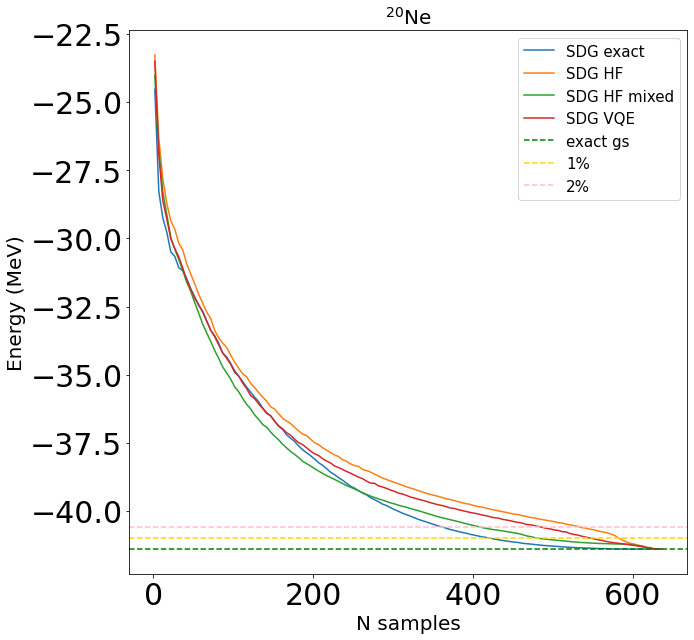

(128,)


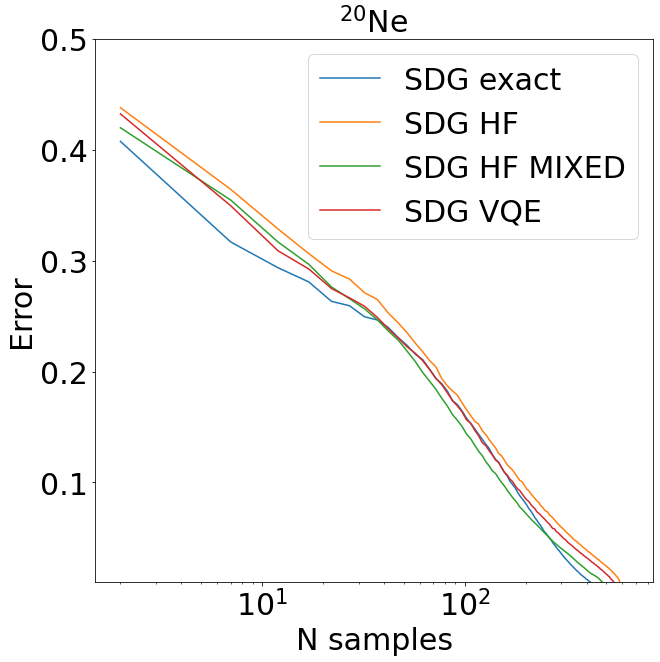

In [58]:
plt.figure(figsize=(10,10))
deviations_vqe=np.abs(np.asarray(deviations_vqe))
deviations=np.abs(np.asarray(deviations))
deviations_exact=np.abs(np.asarray(deviations_exact))
deviations_mixed=np.abs(np.asarray(deviations_mixed))
# plt.errorbar(ns_instances,energies_sdg_gs,yerr=deviations_exact[:,0],label='SDG exact')
# plt.errorbar(ns_instances,energies_sdg_hf,yerr=deviations[:,0],label='SDG HF')
# plt.errorbar(ns_instances,energies_sdg_hf_mixed,yerr=deviations_mixed[:,0],label='SDG HF mixed')
# plt.errorbar(ns_instances,energies_sdg_vqe,yerr=deviations_vqe[:,0],label='SDG VQE')

plt.plot(ns_instances,energies_sdg_gs,label='SDG exact')
plt.plot(ns_instances,energies_sdg_hf,label='SDG HF')
plt.plot(ns_instances,energies_sdg_hf_mixed,label='SDG HF mixed')
plt.plot(ns_instances,energies_sdg_vqe,label='SDG VQE')

#plt.axhline(y=model().detach().numpy(),color='red',linestyle='--',label='HF')
plt.axhline(y=egs[0],color='green',linestyle='--',label='exact gs')
plt.axhline(y=egs[0]*(0.99),color='gold',linestyle='--',label='1%')
plt.axhline(y=egs[0]*(0.98),color='pink',linestyle='--',label='2%')
plt.xlabel('N samples',fontsize=20)
plt.ylabel('Energy (MeV)',fontsize=20)
plt.legend(fontsize=15)
plt.title(title,fontsize=20)
plt.tick_params(labelsize=30)
plt.show()

energies_sdg_hf=np.asarray(energies_sdg_hf)
energies_sdg_gs=np.asarray(energies_sdg_gs)
energies_sdg_hf_mixed=np.asarray(energies_sdg_hf_mixed)
energies_sdg_vqe=np.asarray(energies_sdg_vqe)
print(energies_sdg_hf_mixed.shape)
plt.figure(figsize=(10,10))
plt.plot(ns_instances,np.abs((energies_sdg_gs-egs[0])/egs[0]),label='SDG exact')
plt.plot(ns_instances,np.abs((energies_sdg_hf-egs[0])/egs[0]),label='SDG HF')
plt.plot(ns_instances,np.abs((energies_sdg_hf_mixed-egs[0])/egs[0]),label='SDG HF MIXED')
plt.plot(ns_instances,np.abs((energies_sdg_vqe-egs[0])/egs[0]),label='SDG VQE')
plt.xlabel('N samples',fontsize=30)
plt.ylabel('Error',fontsize=30)
plt.tick_params(labelsize=30)
plt.ylim([10**-2,0.3])

plt.title(title,fontsize=30)
plt.semilogx()
plt.ylim([0.01,0.5])
plt.legend(fontsize=30)
plt.show()